In [1]:
import cv2
import os
import mediapipe as mp
import scipy
from scipy.signal import find_peaks, argrelmin
import matplotlib.pyplot as plt
import tkinter as tk
import pandas as pd
import numpy as np

In [2]:
# initialize Pose estimator
def init_estimator(path):
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose

    pose = mp_pose.Pose(
        min_detection_confidence=0.6,
        min_tracking_confidence=0.6)
    
    return mp_drawing, mp_pose, pose

In [9]:
# Display the vidoe with the keypoints and skeleton
def display_video(video_path, mp_drawing, mp_pose, pose):
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        _, frame = cap.read()

        try:
            RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = pose.process(RGB)

            if results.pose_landmarks is not None:
                # Create a dictionary to map keypoints to labels
                keypoints_labels = {
                    mp_pose.PoseLandmark.LEFT_ANKLE: 'LEFT ANKLE',
                    mp_pose.PoseLandmark.RIGHT_ANKLE: 'RIGHT ANKLE',
                }

                for landmark in mp_pose.PoseLandmark:
                    if landmark in keypoints_labels.keys():
                        landmark_index = landmark.value
                        landmark_name = keypoints_labels[landmark]
                        data_point = results.pose_landmarks.landmark[landmark_index]
                        x = data_point.x * frame.shape[1]  # Multiply by width to get x-coordinate in pixels
                        y = data_point.y * frame.shape[0]  # Multiply by height to get y-coordinate in pixels

                        # Draw a label near the keypoint
                        cv2.putText(frame, f"{landmark_name}", (int(x), int(y) - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

            # Draw detected skeleton on the frame
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Show the final output
            cv2.imshow('Output', frame)

        except:
            break

        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()



In [3]:
# Create a dataframe with coordinates for important keypoints
def record_keypoints(video_path, mp_pose, pose):
    cap = cv2.VideoCapture(video_path)

    time = []

    right_ankle_x = []
    right_ankle_y = []

    left_ankle_x = []
    left_ankle_y = []

    right_heel_x = []
    right_heel_y = []

    left_heel_x = []
    left_heel_y = []

    right_knee_x = []
    right_knee_y = []

    left_knee_x = []
    left_knee_y = []

    right_foot_index_x = []
    right_foot_index_y = []

    left_foot_index_x = []
    left_foot_index_y = []

    right_hip_x = []
    right_hip_y = []

    left_hip_x = []
    left_hip_y = []

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print("Frame Width:", frame_width, "pixels\n")

    while cap.isOpened():
        # Read frame from capture object
        _, frame = cap.read()

        try:
            # Convert the frame to RGB format
            RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the RGB frame to get the result
            results = pose.process(RGB)

            if results.pose_landmarks is not None:

                keypoints_labels = {
                    mp_pose.PoseLandmark.LEFT_ANKLE: 'LEFT ANKLE',
                    mp_pose.PoseLandmark.LEFT_KNEE: 'LEFT KNEE',
                    mp_pose.PoseLandmark.LEFT_HEEL: 'LEFT HEEL',
                    mp_pose.PoseLandmark.LEFT_FOOT_INDEX: 'LEFT FOOT INDEX',
                    mp_pose.PoseLandmark.LEFT_HIP: 'LEFT HIP',

                    mp_pose.PoseLandmark.RIGHT_ANKLE: 'RIGHT ANKLE',
                    mp_pose.PoseLandmark.RIGHT_KNEE: 'RIGHT KNEE',
                    mp_pose.PoseLandmark.RIGHT_HEEL: 'RIGHT HEEL',
                    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX: 'RIGHT FOOT INDEX',
                    mp_pose.PoseLandmark.RIGHT_HIP: 'RIGHT HIP',
                }

                time.append(cap.get(cv2.CAP_PROP_POS_MSEC))

                for landmark in mp_pose.PoseLandmark:
                    if landmark in keypoints_labels.keys():
                        landmark_index = landmark.value
                        landmark_name = keypoints_labels[landmark]
                        data_point = results.pose_landmarks.landmark[landmark_index]
                        x = data_point.x * frame.shape[1]  
                        y = data_point.y * frame.shape[0]  

                        if landmark == mp_pose.PoseLandmark.RIGHT_ANKLE:
                            right_ankle_x.append(int(x))
                            right_ankle_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_ANKLE:
                            left_ankle_x.append(int(x))
                            left_ankle_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_HEEL:
                            right_heel_x.append(int(x))
                            right_heel_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_HEEL:
                            left_heel_x.append(int(x))
                            left_heel_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_KNEE:
                            right_knee_x.append(int(x))
                            right_knee_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_KNEE:
                            left_knee_x.append(int(x))
                            left_knee_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_FOOT_INDEX:
                            right_foot_index_x.append(int(x))
                            right_foot_index_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_FOOT_INDEX:
                            left_foot_index_x.append(int(x))
                            left_foot_index_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_HIP:
                            right_hip_x.append(int(x))
                            right_hip_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_HIP:
                            left_hip_x.append(int(x))
                            left_hip_y.append(int(y))

        except:
            break

        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Get pelvis position using the average of hip position
    pelvis_x = ((np.array(right_hip_x) + np.array(left_hip_x)) / 2).tolist()

    data = {
        'time': np.array(time) / 1000,
        'right_ankle_x': right_ankle_x,
        'right_ankle_y': right_ankle_y,
        'left_ankle_x': left_ankle_x,
        'left_ankle_y': left_ankle_y,
        'right_heel_x': right_heel_x,
        'right_heel_y': right_heel_y,
        'left_heel_x': left_heel_x,
        'left_heel_y': left_heel_y,
        'right_knee_x': right_knee_x,
        'right_knee_y': right_knee_y,
        'left_knee_x': left_knee_x,
        'left_knee_y': left_knee_y,
        'right_foot_index_x': right_foot_index_x,
        'right_foot_index_y': right_foot_index_y,
        'left_foot_index_x': left_foot_index_x,
        'left_foot_index_y': left_foot_index_y,
        'right_hip_x': right_hip_x,
        'right_hip_y': right_hip_y,
        'left_hip_x': left_hip_x,
        'left_hip_y': left_hip_y,
        'pelvis_x': pelvis_x
    }

    df = pd.DataFrame(data)
    print(df)
    
    return df, frame_width


In [4]:
def plot_y_keypoints(dataframe, keypoints_names, title):
    plt.figure(figsize=(10, 6))
    for i in range(len(keypoints_names)):
        x_col = f'{keypoints_names[i]}_x'
        y_col = f'{keypoints_names[i]}_y'
        
        plt.scatter(dataframe['time'], dataframe[y_col], label=f'{keypoints_names[i]} y', s=20)
        plt.plot(dataframe['time'], dataframe[y_col], label=f'{keypoints_names[i]} y')
        
    plt.xlabel('Time (seconds)')
    plt.ylabel('Vertical Position (pixels)')
    plt.title('Vertical ' + title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_x_keypoints(dataframe, keypoints_names, title):
    plt.figure(figsize=(10, 6))
    for i in range(len(keypoints_names)):
        x_col = f'{keypoints_names[i]}_x'
        y_col = f'{keypoints_names[i]}_y'

        plt.scatter(dataframe['time'], dataframe[x_col], label=f'{keypoints_names[i]} x', s=20)
        plt.plot(dataframe['time'], dataframe[x_col], label=f'{keypoints_names[i]} x')
        
    plt.xlabel('Time (seconds)')
    plt.ylabel('Horizontal Position (pixels)')
    plt.title('Horizontal ' + title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def graph_x_positions():
    ankles_keypoints = ['right_ankle', 'left_ankle']
    heels_keypoints = ['right_heel', 'left_heel']
    toe_indices_keypoints = ['right_foot_index', 'left_foot_index']

    plot_x_keypoints(df, ankles_keypoints, 'Ankle Movement Over Time')
    # plot_x_keypoints(df, heels_keypoints, 'Heels Movement Over Time')
    # plot_x_keypoints(df, toe_indices_keypoints, 'Toe Indices Movement Over Time')
    
def graph_y_positions():
    ankles_keypoints = ['right_ankle', 'left_ankle']
    heels_keypoints = ['right_heel', 'left_heel']
    toe_indices_keypoints = ['right_foot_index', 'left_foot_index']
    
    plot_y_keypoints(df, ankles_keypoints, 'Ankles Movement Over Time')
    # plot_y_keypoints(df, heels_keypoints, 'Heels Movement Over Time')
    # plot_y_keypoints(df, toe_indices_keypoints, 'Toe Indices Movement Over Time')

In [6]:
def swap(df, index, left_landmark, right_landmark, leftCurr, rightCurr):
    df.at[index, left_landmark] = rightCurr
    df.at[index, right_landmark] = leftCurr
    
def swap_in_range(df, start, end, left_landmark, right_landmark):
    for index, row in df.iterrows():
        if start <= row['time'] <= end:
            left_curr_value = row[left_landmark]
            right_curr_value = row[right_landmark]
            swap(df, index, left_landmark, right_landmark, left_curr_value, right_curr_value)

def swap_keypoints_range(start, end):       
    swap_in_range(df, start, end, "left_ankle_x", "right_ankle_x")
    swap_in_range(df, start, end, "left_heel_x", "right_heel_x")
    swap_in_range(df, start, end, "left_foot_index_x", "right_foot_index_x")

In [7]:
def distance_between(curr, prev):
    return abs(curr - prev)

# Swaps incorrectly classified right - left keypoints
def switch_left_right(df, left_landmark, right_landmark, threshold=30, window_size=3):
    leftPrev = df[left_landmark].iloc[0]
    rightPrev = df[right_landmark].iloc[0]
    
    for index, rows in df.iterrows():
        leftCurr = df[left_landmark].iloc[index]
        rightCurr = df[right_landmark].iloc[index]
        
        leftDif = distance_between(leftCurr, leftPrev)
        rightDif = distance_between(rightCurr, rightPrev)
        
        # Swap points distance between current and previous point exceeeds threshold
        if leftDif > threshold and rightDif > threshold:
            swap(df, index, left_landmark, right_landmark, leftCurr, rightCurr)
            
        # Recalculate current distances
        newLeft = df[left_landmark].iloc[index]
        newRight = df[right_landmark].iloc[index]
        
        # If a point exceeds the threshold after a swap, correct the point with a moving average
        if distance_between(newLeft, leftPrev) > threshold:
            left_ma = df[left_landmark].iloc[max(0, index - window_size + 1):index + 1].mean()
            df.at[index, left_landmark] = left_ma
            
        if distance_between(newRight, rightPrev) > threshold:
            right_ma = df[right_landmark].iloc[max(0, index - window_size + 1):index + 1].mean()
            df.at[index, right_landmark] = right_ma

        leftPrev = df[left_landmark].iloc[index]
        rightPrev = df[right_landmark].iloc[index]
        
def swap_keypoints():
    switch_left_right(df, "left_ankle_x", "right_ankle_x")
    switch_left_right(df, "left_heel_x", "right_heel_x")
    switch_left_right(df, "left_foot_index_x", "right_foot_index_x")

In [8]:
# Calculates the horizontal distance between the ankles and pelvis
def calc_distance_ankle_pelvis(ankle, title):
    pelvis_x = df['pelvis_x']
    ankle_x = df[ankle]
    ankle_pelvis_distance = ankle_x - pelvis_x
    time = df['time']

    plt.plot(time, ankle_pelvis_distance, linestyle='-')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Ankle-Pelvis Horizontal Distance (Pixels)')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    return ankle_pelvis_distance

def create_ankle_pelvis_df(df):
    df_ankle_pelvis = pd.DataFrame()
    df_ankle_pelvis['time'] = df['time']

    df_ankle_pelvis['right_ankle_pelvis_x'] = calc_distance_ankle_pelvis('right_ankle_x', 'Right Ankle-Pelvis Horizontal Distance over Time')
    df_ankle_pelvis['left_ankle_pelvis_x'] = calc_distance_ankle_pelvis('left_ankle_x', 'Left Ankle-Pelvis Horizontal Distance over Time')
    df_ankle_pelvis.head()
    return df_ankle_pelvis

In [9]:
def calc_extrema(df, keypoint, max_range=10):
    # Find local maxima using find_peaks with width parameter
    max_peaks, _ = find_peaks(df[keypoint].values, width=max_range)
    max_peak_values = df[keypoint].iloc[max_peaks]
    max_peak_times = df['time'].iloc[max_peaks]
    
    # Find local minima using find_peaks with width parameter
    min_peaks, _ = find_peaks(-df[keypoint].values, width=max_range)
    min_peak_values = df[keypoint].iloc[min_peaks]
    min_peak_times = df['time'].iloc[min_peaks]
    
    # Sort maxima and minima indices by values
    sorted_max_indices = np.argsort(max_peak_values)
    sorted_min_indices = np.argsort(min_peak_values)
    
    selected_max_indices = max_peaks[sorted_max_indices]
    selected_min_indices = min_peaks[sorted_min_indices]
    
    selected_max_values = df[keypoint].iloc[selected_max_indices]
    selected_max_times = df['time'].iloc[selected_max_indices]
    
    selected_min_values = df[keypoint].iloc[selected_min_indices]
    selected_min_times = df['time'].iloc[selected_min_indices]
    
    plt.plot(df['time'], df[keypoint])
    plt.plot(selected_max_times, selected_max_values, 'ro', label='Heel-Down')
    plt.plot(selected_min_times, selected_min_values, 'bo', label='Toe-Off')
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Ankle-Pelvis Horizontal Distance (Pixels)')
    plt.title('Ankle-Pelvis Horizontal Distance over Time with Extrema')
    plt.legend()
    plt.show()
    
    max_array = np.array([selected_max_times, selected_max_values]).T
    min_array = np.array([selected_min_times, selected_min_values]).T
    
    # Sort the arrays by time
    max_array.sort(axis=0)  
    min_array.sort(axis=0)  

    return max_array, min_array

In [10]:
# Calculates the time of midpoints between toe offs and heel strikes
def calc_midpoints(arr_1, arr_2):
    index_1 = 0
    index_2 = 0
    time_dif = []
    
    while index_1 < arr_1.shape[0] and index_2 < arr_2.shape[0]:
        time_1 = arr_1[index_1, 0]
        time_2 = arr_2[index_2, 0]

        index_2 += 1
        if time_1 <= time_2:
            time_dif.append(time_2 - time_1)
            index_1 += 1
            
#         print(str(time_1) + " " + str(time_2))
    
    np_time_dif = np.array(time_dif)

In [11]:
# Calculates the angle in degrees between 3 keypoints
def calc_angle_between(df, keypoint_1, keypoint_2, keypoint_3):
    angles = []
    for index, row in df.iterrows():
        
        # X Y coordinates for each keypoint
        coordinates = {
            keypoint_1: np.array([row[keypoint_1 + '_x'], row[keypoint_1 + '_y']]),
            keypoint_2: np.array([row[keypoint_2 + '_x'], row[keypoint_2 + '_y']]),
            keypoint_3: np.array([row[keypoint_3 + '_x'], row[keypoint_3 + '_y']])
        }
        
        vector1 = coordinates[keypoint_1] - coordinates[keypoint_2]
        vector2 = coordinates[keypoint_3] - coordinates[keypoint_2]
        
        dot_product = np.dot(vector1, vector2)
        magnitude1 = np.linalg.norm(vector1)
        magnitude2 = np.linalg.norm(vector2)
        
        cos_angle = dot_product / (magnitude1 * magnitude2)
        
        angle_radians = np.arccos(cos_angle)
        angle_degrees = np.degrees(angle_radians)
        
        angles.append(angle_degrees)
        
    return angles

In [12]:
def graphKneeAngles(df_angles):
    plt.plot(df_angles['time'], df_angles['right_knee_angles'], label='Right Knee Angle')
    plt.plot(df_angles['time'], df_angles['left_knee_angles'], label='Left Knee Angle')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Angle (degrees)')
    plt.title('Knee Angle over Time')
    plt.legend()
    plt.grid()
    plt.show()

def graphAnkleAngles(df_angles):
    plt.plot(df_angles['time'], df_angles['right_ankle_angles'], label='Right Ankle Angle')
    plt.plot(df_angles['time'], df_angles['left_ankle_angles'], label='Left Ankle Angle')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Angle (degrees)')
    plt.title('Ankle Angle over Time')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
def calc_keypoint_angles(df):
    df_angles = pd.DataFrame()
    df_angles['time'] = df['time']

    df_angles['right_knee_angles'] = calc_angle_between(df, 'right_hip', 'right_knee', 'right_ankle')
    df_angles['left_knee_angles'] = calc_angle_between(df, 'left_hip', 'left_knee', 'left_ankle')

    df_angles['right_ankle_angles'] = calc_angle_between(df, 'right_knee', 'right_ankle', 'right_foot_index')
    df_angles['left_ankle_angles'] = calc_angle_between(df, 'left_knee', 'left_ankle', 'left_foot_index')

    graphKneeAngles(df_angles)
    # graphAnkleAngles(df_angles)
    df_angles.head()
    
    return df_angles

In [14]:
# Find knee and ankle angles at heel-strikes and toe-offs
def get_angles_at_event(df, event_arr, event):
    angles = []
    for i in range(0, len(event_arr)):
        time = event_arr[i, 0]
        angle = df[df['time'] == time][event].values[0]
        angles.append(angle)
#     print(angles)
    return angles

In [17]:
def get_angle_keypoints():

    # Angles at left heel-strikes
    right_knee_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, left_heel_strike, 'left_ankle_angles')

    # Angles at right heel-strikes
    right_knee_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, right_heel_strike, 'left_ankle_angles')

    # Angles at left toe-offs
    right_knee_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, left_toe_off, 'left_ankle_angles')

    # Angles at right toe-offs
    right_knee_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'right_knee_angles')
    left_knee_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'left_knee_angles')
    right_ankle_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'right_ankle_angles')
    left_ankle_angles_left_heel = get_angles_at_event(df_angles, right_toe_off, 'left_ankle_angles')

In [18]:
# Calculates time betweeen consecutive points in the array
def calc_step_time(arr):
    time_dif = []
    
    for i in range(0, len(arr) - 1):
        dif = arr[i + 1, 0] - arr[i, 0]
        time_dif.append(dif)
        
    np_time_dif = np.array(time_dif)
    mean = np.mean(np_time_dif)
    std = np.std(np_time_dif)
    
#     print(time_dif)
    
    return mean, std

In [19]:
# Calculates time between consecutive points in arr_1 and arr_2, where arr_1 contains the initial event and arr_2 contains the final event
def calc_time_between(arr_1, arr_2):
    index_1 = 0
    index_2 = 0
    time_dif = []
    
    while index_1 < arr_1.shape[0] and index_2 < arr_2.shape[0]:
        time_1 = arr_1[index_1, 0]
        time_2 = arr_2[index_2, 0]

        index_2 += 1
        if time_1 <= time_2:
            time_dif.append(time_2 - time_1)
            index_1 += 1
            
#         print(str(time_1) + " " + str(time_2))
    
    np_time_dif = np.array(time_dif)
    mean = np.mean(np_time_dif)
    std = np.std(np_time_dif)
    
    return mean, std


In [20]:
def calc_step_length(toe_arr, heel_arr, frame_width, walkway_length):
    toe_index = 0
    heel_index = 0
    step_length = []
    
    while heel_index < heel_arr.shape[0] and toe_index < toe_arr.shape[0]:
        heel_time, heel_position = heel_arr[heel_index]
        toe_time, toe_position = toe_arr[toe_index]

        heel_index += 1
        if toe_time <= heel_time:
            step_length.append(heel_position - toe_position)
            toe_index += 1
            
            print(str(toe_position) + " " + str(heel_position))
    
    meters_per_pixel = walkway_length / frame_width
    
    step_length = np.array(step_length) * meters_per_pixel
    print(step_length)
    mean = np.mean(step_length)
    std = np.std(step_length)
    return mean, std

In [21]:
def get_features(left_heel_strike, right_heel_strike, left_toe_off, right_toe_off, frame_width):
    # Step Time: duration in seconds between consecutive bilateral heel-strikes.
    left_step_mean, left_step_std = calc_step_time(left_heel_strike)
    right_step_mean, right_step_std = calc_step_time(right_heel_strike)

    # Stance time: duration in seconds between heel-strike and toe-off of the same leg
    left_stance_mean, left_stance_std = calc_time_between(left_heel_strike, left_toe_off)
    right_stance_mean, right_stance_std = calc_time_between(right_heel_strike, right_toe_off)

    # Swing time: duration in seconds between toe-off and heel-strike of the same leg
    left_swing_mean, left_swing_std = calc_time_between(left_toe_off, left_heel_strike)
    right_swing_mean, right_swing_std = calc_time_between(right_toe_off, right_heel_strike)

    # Double support time: duration in seconds between heel-strike of one leg and toe-off of the contralateral leg.
    left_dst_mean, left_dst_std = calc_time_between(left_heel_strike, right_toe_off)
    right_dst_mean, right_dst_std = calc_time_between(right_heel_strike, left_toe_off)
    dst_mean = (left_dst_mean, right_dst_mean)
    dst_std = np.sqrt((left_dst_std**2 + right_dst_std**2) / 2)

    # Step length: anterior-posterior distance in meters between ankle keypoints at heel-strike.
    walkway_length = 6.3;
    left_step_length_mean, left_step_length_std = calc_step_length(left_toe_off, left_heel_strike, frame_width, walkway_length)
    right_step_length_mean, right_step_length_std = calc_step_length(right_toe_off, right_heel_strike, frame_width, walkway_length)

    # Gait speed: step length divided by step time.
    left_gait_speed_mean = left_step_length_mean / left_step_mean
    right_gait_speed_mean = right_step_length_mean / right_step_mean

    features = {
        'left_step_mean': left_step_mean,
        'left_step_std': left_step_std,
        'right_step_mean': right_step_mean,
        'right_step_std': right_step_std,

        'left_stance_mean': left_stance_mean,
        'left_stance_std': left_stance_std,
        'right_stance_mean': right_stance_mean,
        'right_stance_std': right_stance_std,

        'left_swing_mean': left_swing_mean,
        'left_swing_std': left_swing_std,
        'right_swing_mean': right_swing_mean,
        'right_swing_std': right_swing_std,

        'dst_mean': dst_mean,
        'dst_std': dst_std,

        'left_step_length_mean': left_step_length_mean,
        'left_step_length_std': left_step_length_std,
        'right_step_length_mean': right_step_length_mean,
        'right_step_length_std': right_step_length_std,

        'left_gait_speed_mean': left_gait_speed_mean,
        'right_gait_speed_mean': right_gait_speed_mean
    }

    df_spatial_features = pd.DataFrame(features).drop(1)
    return df_spatial_features


Frame Width: 1280 pixels

         time  right_ankle_x  right_ankle_y  left_ankle_x  left_ankle_y  \
0    0.700000            103            560           179           561   
1    0.733333            103            561           180           553   
2    0.766667            103            561           184           551   
3    0.800000            104            561           188           552   
4    0.833333            104            561           192           553   
..        ...            ...            ...           ...           ...   
160  6.033333           1229            595          1207           582   
161  6.066667           1238            593          1231           587   
162  6.100000           1255            594          1243           591   
163  6.133333           1261            594          1243           593   
164  6.166667           1269            598          1238           599   

     right_heel_x  right_heel_y  left_heel_x  left_heel_y  right_knee_x  

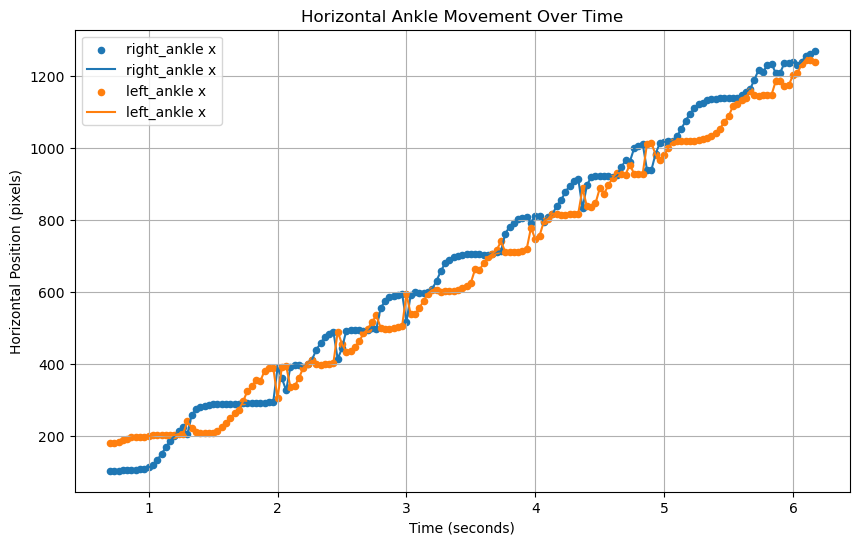

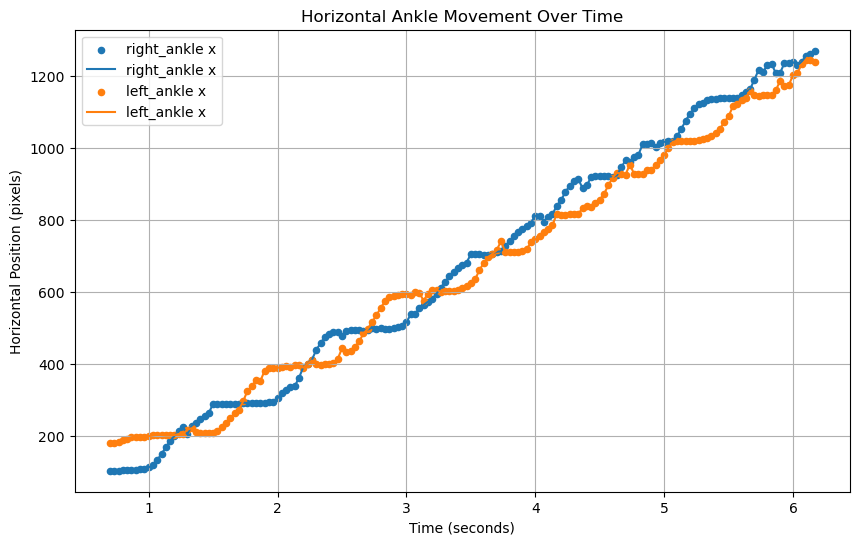

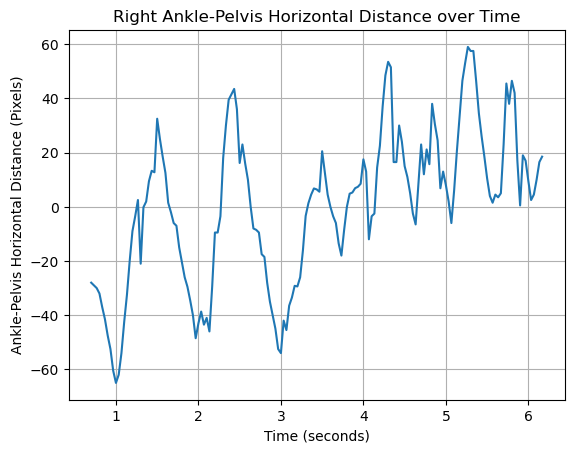

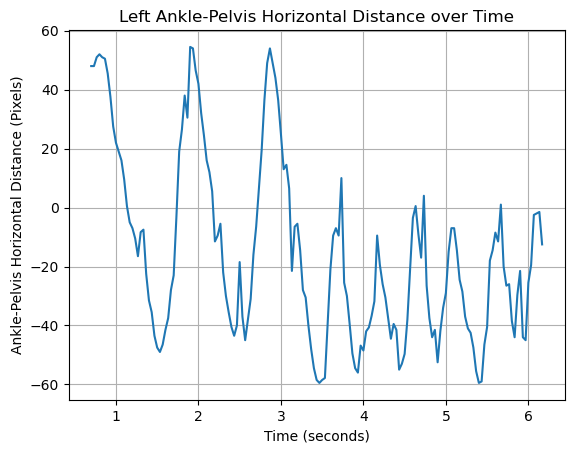

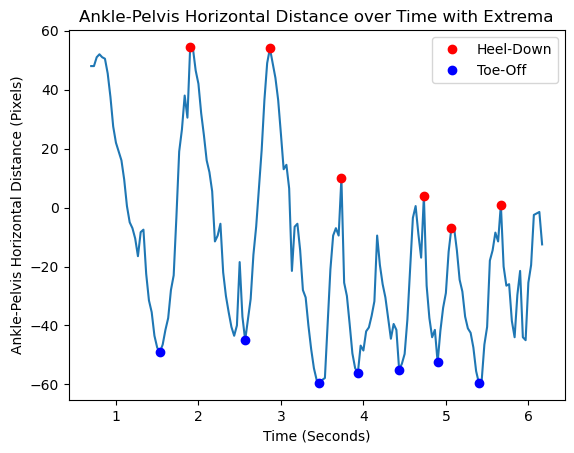

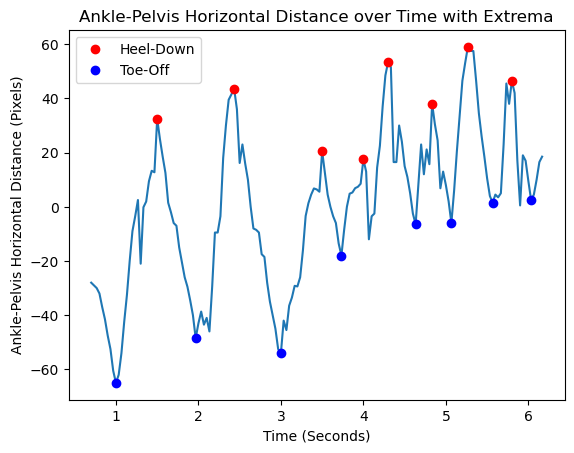

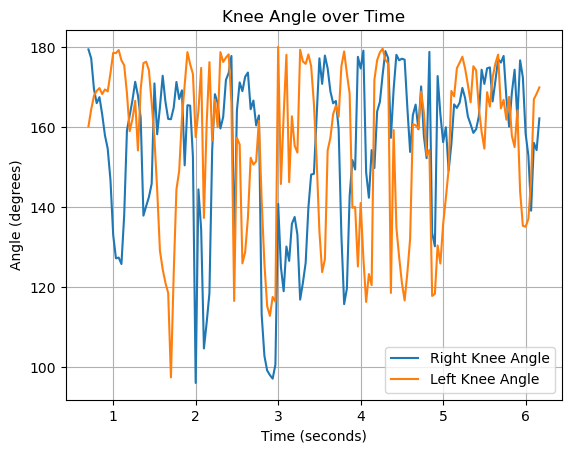

-59.5 -7.0
-59.5 1.0
-56.0 4.0
-55.0 10.0
-52.5 54.0
-49.0 54.5
[0.25839844 0.29777344 0.2953125  0.31992188 0.52417969 0.50941406]
-65.0 17.5
-54.0 20.5
-48.5 32.5
-18.0 38.0
-6.5 46.5
-6.0 53.5
1.5 59.0
[0.40605469 0.36667969 0.39867188 0.275625   0.26085938 0.29285156
 0.28300781]
Frame Width: 1280 pixels

         time  right_ankle_x  right_ankle_y  left_ankle_x  left_ankle_y  \
0    0.833333              1            573           100           568   
1    0.866667              3            573           100           568   
2    0.900000              4            573           101           569   
3    0.933333              8            571           103           569   
4    0.966667             11            569           105           571   
..        ...            ...            ...           ...           ...   
190  7.166667           1145            597          1138           595   
191  7.200000           1146            597          1138           595   
192  7.233333 

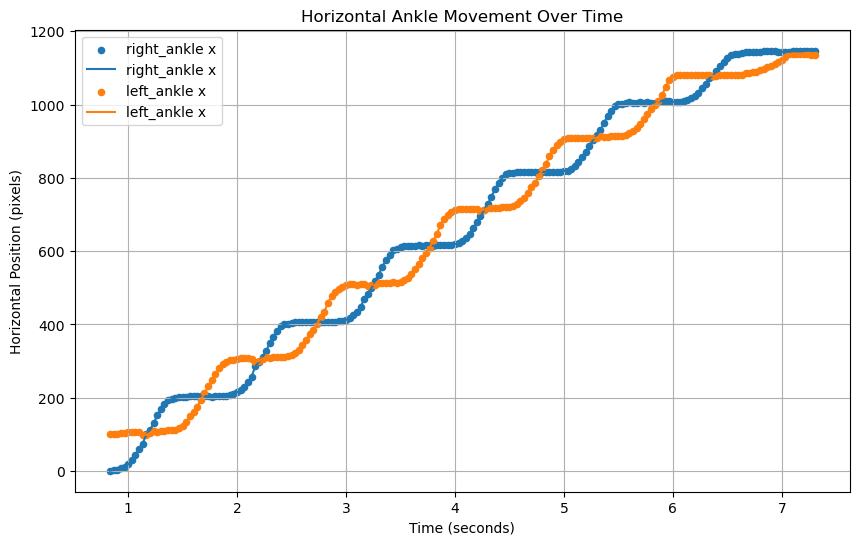

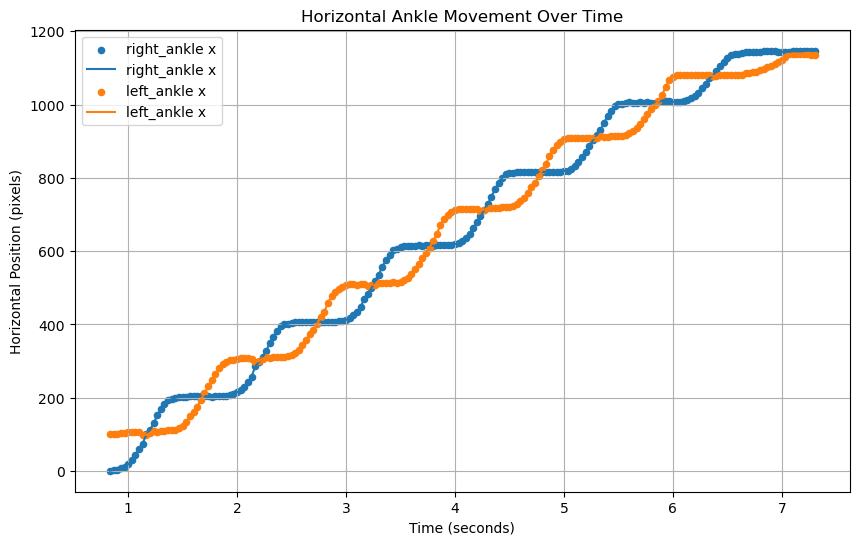

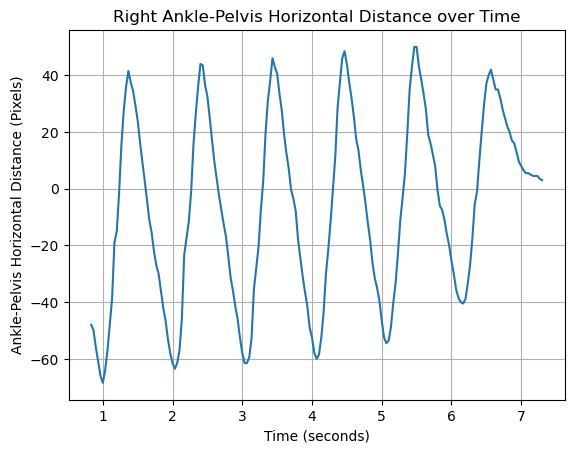

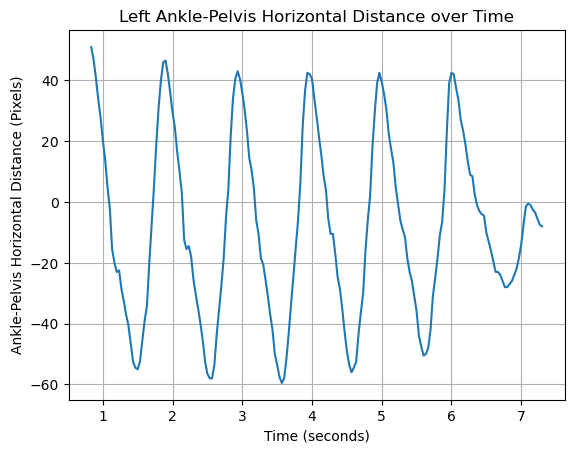

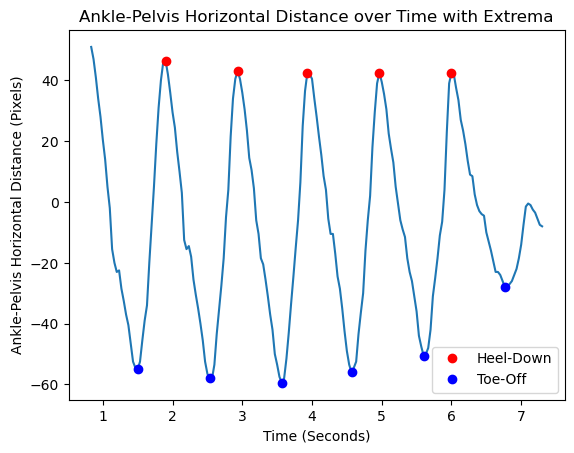

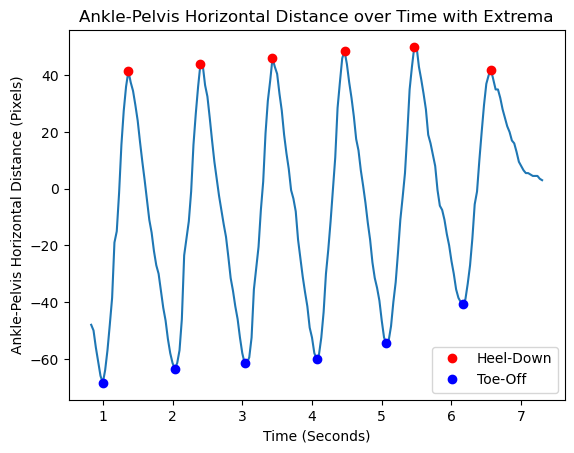

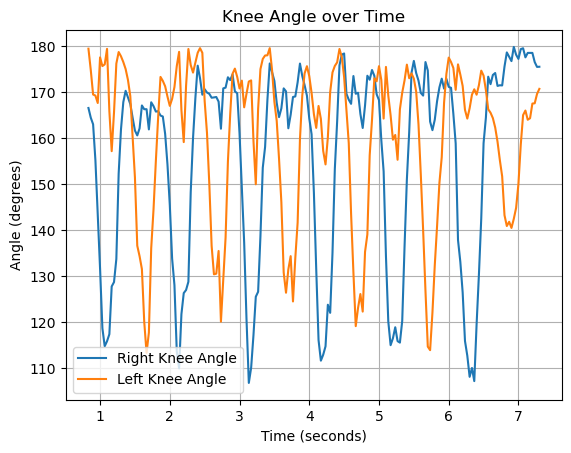

-59.5 42.5
-58.0 42.5
-56.0 42.5
-55.0 43.0
-50.5 46.5
[0.50203125 0.49464844 0.48480469 0.48234375 0.47742187]
-68.5 41.5
-63.5 42.0
-61.5 44.0
-60.0 46.0
-54.5 48.5
-40.5 50.0
[0.54140625 0.51925781 0.51925781 0.52171875 0.50695313 0.44542969]


,left_step_mean,left_step_std,right_step_mean,right_step_std,left_stance_mean,left_stance_std,right_stance_mean,right_stance_std,left_swing_mean,left_swing_std,right_swing_mean,right_swing_std,dst_mean,dst_std,left_step_length_mean,left_step_length_std,right_step_length_mean,right_step_length_std,left_gait_speed_mean,right_gait_speed_mean
0,0.753333,0.252631,0.614286,0.257495,0.393333,0.204831,0.595238,0.180325,0.522222,0.219145,0.338095,0.132651,0.233333,0.195789,0.36750,0.107182,0.326250,0.057411,0.487832,0.531105
1,1.025000,0.014434,1.040000,0.032660,0.660000,0.053333,0.646667,0.033993,0.393333,0.013333,0.388889,0.015713,0.126667,0.027543,0.48825,0.008887,0.509004,0.030188,0.476341,0.489427


In [22]:
video_folder = "sagittal_videos"

# List all files in the folder
file_list = os.listdir(video_folder)

# Filter video files
video_files = [filename for filename in file_list if filename.endswith('.mp4')]

df_features = pd.DataFrame()

for video_filename in video_files:
    video_path = os.path.join(video_folder, video_filename)
    mp_drawing, mp_pose, pose = init_estimator(video_path)
    
    # Video display
    # display_video(video_path, mp_drawing, mp_pose, pose)
    
    # Create dataframe of keypoint positions
    df, frame_width = record_keypoints(video_path, mp_pose, pose)
    df.head()
    
    # Initial keypoint positions
    graph_x_positions()
    
    # Switch incorrectly labeled left - right keypooints
    swap_keypoints()
    graph_x_positions()
    
    # Get the distance betweeen ankle and pelvis keypoints
    df_ankle_pelvis = create_ankle_pelvis_df(df)
    
    # Calculate heel strike and toe off events
    left_heel_strike, left_toe_off = calc_extrema(df_ankle_pelvis, 'left_ankle_pelvis_x', max_range=5)
    right_heel_strike, right_toe_off = calc_extrema(df_ankle_pelvis, 'right_ankle_pelvis_x', max_range=3)

#     print("Left Heel Strikes:\n", left_heel_strike)
#     print("\nLeft Toe-Offs:\n", left_toe_off)

#     print("\nRight Heel Strikes:\n", right_heel_strike)
#     print("\nRight Toe-Offs:\n", right_toe_off)
    
    # Caluclate the midpoints between left toe offs and left heel strike
    left_midpoints = calc_midpoints(left_toe_off, left_heel_strike)

    # Caluclate the midpoints between right toe offs and right heel strike
    right_midpoints = calc_midpoints(right_toe_off, right_heel_strike)
    
    # Calculate ankle and knee angles over time
    df_angles = calc_keypoint_angles(df)
    
    # Calculate features for the current video
    features = get_features(left_heel_strike, right_heel_strike, left_toe_off, right_toe_off, frame_width)
    df_features = pd.concat([df_features, features], ignore_index=True)
    
df_features.head()
    